In [1]:
import matplotlib.pyplot as plt
import numpy as np
#!pip3 install tqdm
#!pip3 install --no-cache-dir -I pillow
from tqdm import tqdm

%matplotlib inline

In [2]:
#!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
#!pip3 install torchvision

import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (30,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

#  Read db and apply data augmentation

In [6]:
#!git clone https://github.com/fgvenegas/Deep-Learning-Pokemon-Image-Generator.git

In [62]:
dataset = dset.ImageFolder(root="root",
       transform=transforms.Compose([
       transforms.Resize(size=[64,64]),
       transforms.RandomHorizontalFlip(),
       transforms.ColorJitter(brightness=0.1, contrast=1.1),
       transforms.RandomVerticalFlip(),
       transforms.RandomRotation(degrees=[0.2, 0.8]),
       transforms.ToTensor(),
]))

In [63]:
#image = tf.image.random_flip_left_right(image)
#image = tf.image.random_brightness(image, max_delta = 0.1)
#image = tf.image.random_contrast(image, lower = 0.9, upper = 1.1)

In [77]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                         shuffle=True, num_workers=int(2))

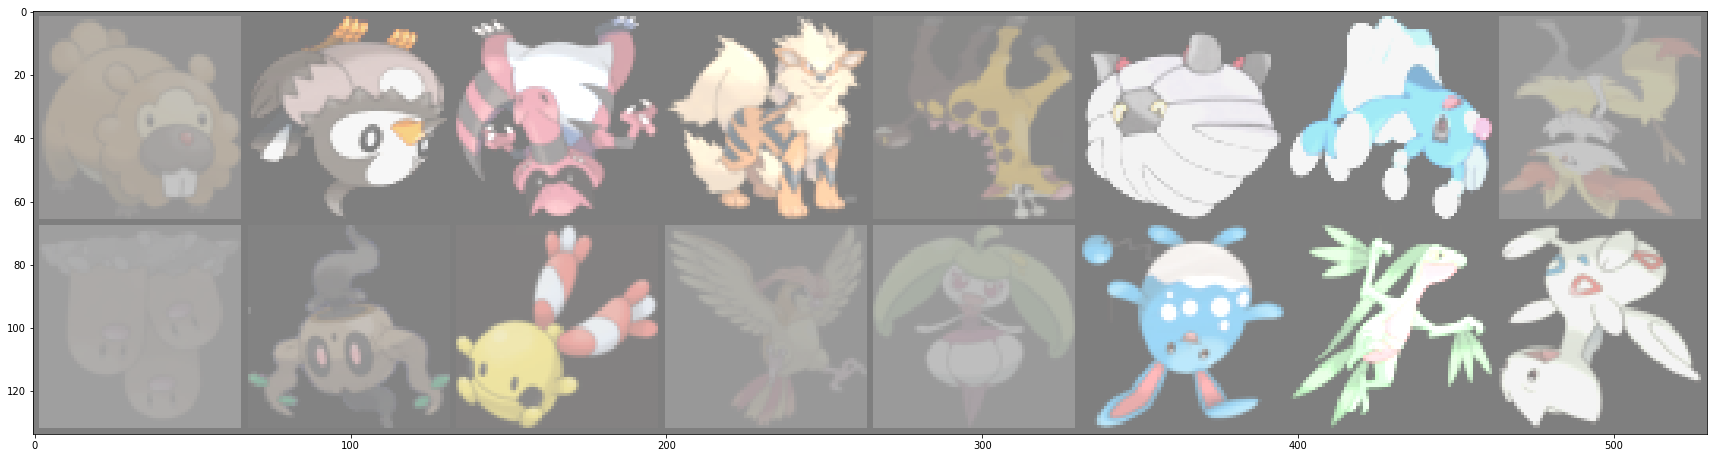

In [78]:
# get some random training images
dataiter = iter(dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [79]:
for i, data in enumerate(dataloader, 0):
    test, _ = data
    print(test.shape, len(dataloader))
    break


torch.Size([16, 3, 64, 64]) 51


# Gan Model

In [75]:
nc = 3   # n_channels = 3, color image.
ndf = 128 # n_filters disc
ngf = 128 # n_filters gen
nz = 100 # z dimension
batch_size = 16


### Discriminator

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.ngpu = 1
        self.main = nn.Sequential(
            # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
            #                 padding=0, dilation=1, groups=1, bias=True)
            # Bias False It is because BN eliminates the bias (why?), and BN 
            # (with affine=True) adds a bias so it’s equivalent.
            # Input Size nc x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), #inplace doesn't accumulate memory
            # First layer not apply BN
            # Size ndf x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Size ndf*2 x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Size ndf*4 x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            ## Size ndf*8 x 8 x 8
            ## nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            ## nn.BatchNorm2d(ndf * 16),
            ## nn.LeakyReLU(0.2, inplace=True),
            # Size ndf * 8 x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()

        )
    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)
    
    

In [15]:
D = Discriminator()

In [16]:
print(D)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU(0.2, inplace)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU(0.2, inplace)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Generator

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.ngpu=1
        self.main = nn.Sequential(
            # Deconvolution layer is a very unfortunate name and should rather
            # be called a transposed convolutional layer.
            # https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers
            ##nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            ##nn.BatchNorm2d(ngf * 16),
            ##nn.ReLU(True),
            ## Size ngf * 8 x 4 x 4

            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Size ngf * 8 x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Size ngf * 4 x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Size ngf * 2 x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Size ngf x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Size nc x 64 x 64
        )

    def forward(self, x):
        return self.main(x)

In [19]:
G = Generator()

In [20]:
print(G)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Setup

In [21]:
criterion = nn.BCELoss() # I'll always compare the answer of the discriminator
                         # with the Discrimintor using real and fake data and 
                         # with the Generator using only the fake data

In [22]:
input = torch.FloatTensor(batch_size, 3, 128, 128)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
#fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1) # For test generation
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [23]:
# CUDA
use_cuda = True

if use_cuda and torch.cuda.is_available():
    D.cuda()
    G.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise = noise.cuda()

In [24]:
optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [74]:
n_epochs = 1

In [ ]:
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader, 0):
        # Discriminator update: max log(D(x)) + log(1 - D(G(z)))
        ## Real training 
        D.zero_grad()
        real, _ = data
        bs = real.size(0)
        if use_cuda and torch.cuda.is_available():
            real = real.cuda()
        input.resize_as_(real).copy_(real)
        label.resize_(bs).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)
      
        output = D(inputv)
        loss_r = criterion(output, labelv)
        loss_r.backward()
      
        ## Fake training
        noise.resize_(bs, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = G(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = D(fake.detach())
        # The computation of gradients wrt the weights of G can be fully
        # avoided in the backward pass if the graph is detached where it is.
        loss_f = criterion(output, labelv)
        loss_f.backward()
      
        loss_d = loss_r + loss_f
        optimizerD.step()
      
        # Generator update max log(D(G(z)))
        G.zero_grad()
        labelv = Variable(label.fill_(real_label))
        output = D(fake)
        loss_g = criterion(output, labelv)
        loss_g.backward()
        optimizerG.step()
      
        #print("batch size", bs)
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' 
              % (epoch + 1, n_epochs, i + 1, len(dataloader), loss_d, loss_g))
        if i % 50 == 0:
            noise.resize_(16, nz, 1, 1).normal_(0, 1)
            noisev = Variable(noise)
            fake = G(noisev)
            vutils.save_image(fake.data,'FakeSamples/fake_samples_epoch_%03d.png' % (epoch), normalize=True)

# Test

In [27]:
noise.resize_(16, nz, 1, 1).normal_(0, 1)
noisev = Variable(noise)
fake = G(noisev)

In [ ]:
imshow(torchvision.utils.make_grid(fake.data.cpu()))

# Save and Load

In [29]:
#torch.save(G.state_dict(), 'G.pth')
#torch.save(D.state_dict(), 'D.pth')

In [30]:
gen = Generator()
gen.load_state_dict(torch.load('G.pth'))

In [58]:
noise.resize_(32, nz, 1, 1).normal_(0, 1)
noisev = Variable(noise)
fake = gen(noisev)

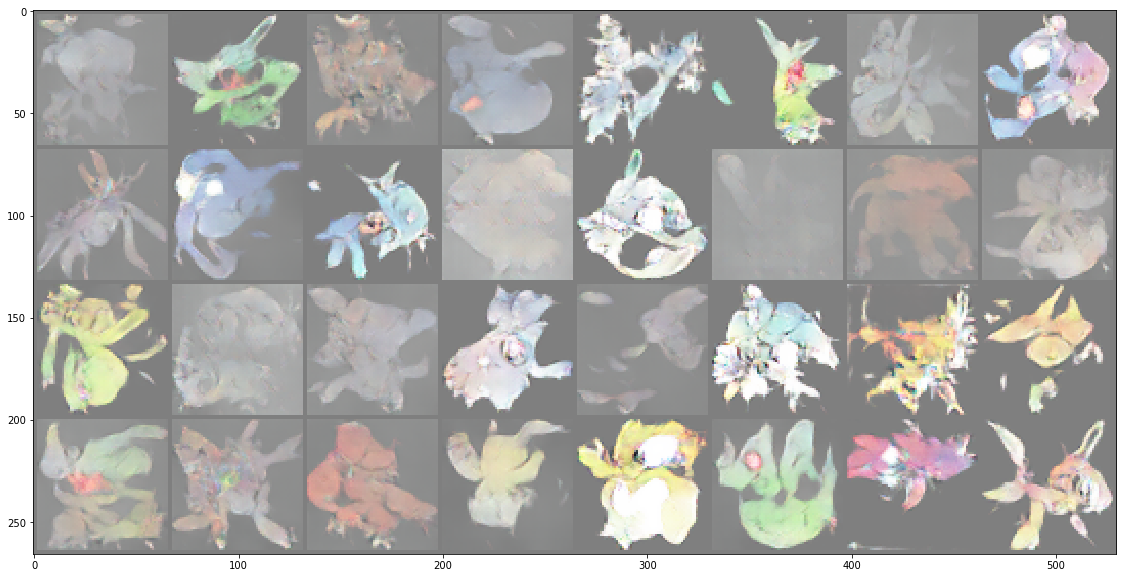

In [59]:
imshow(torchvision.utils.make_grid(fake.data.cpu()))

In [60]:
vutils.save_image(fake.data, 'AwesomeSamples/fake_samples_9.png',normalize=False)